# Analytical solution of foam flooding with BL assumptions

The fractional flow of water is calculated as $$ f_w = \frac {k_{rw}/\mu_w}{k_{rw}/\mu_w+k_{rg}^f/\mu_g} $$ where the relperms can be defined as $$ k_{rw}(S_w) = k_{rw}^0 (S_w^*)^{n_w} $$ and $$ k_{rg}(S_w) = k_{rg}^0 (1-S_w^*)^{n_g} $$ where the normalized water saturation is defined as $$ S_w^* = \frac{S_w - S_{wc}}{1-S_{wc}-S_{or}}. $$ Here we first define the physical properties and then define the relperm functions in Julia. We are going to need PyPlot and Roots in this work.  
The relative permeability of foam is defined by $$k_{rg}^f=k_{rg}/(1+fmmob.F_2)$$ where $F_2$ is defined by $$F_2 = 0.5+\arctan(epdry(S_w-fmdry))/\pi$$

In [1]:
using PyPlot
using Roots

In [2]:
# viscosities
muw = 0.00095
mug = 1.9698e-5
# initialize the Corey model parameters
u = 0.977e-6/(π*0.038^2/4)/60
phi = 0.2
k = 2.428e-12 # [m^2]

#B-R fit:
#fmmob, fmdry, epdry = 1.09213e6, 0.206154, 1.0000e+05
# LS fit, three parameters
fmmob, fmdry, epdry = 85277.1, 0.201264, 15293.2
swc = 0.169997 
sgr = 0.0479002
krg0 = 0.94
ng = 1.8
krw0 = 0.336417 
nw = 2.49292  
sws(sw::Real)=((sw>swc)*(sw<1-sgr)*(sw-swc)/(1-sgr-swc)+(sw>=1-sgr)*1.0)
sws(sw::Array{Float64})=((sw.>swc).*(sw.<1-sgr).*(sw-swc)/(1-sgr-swc)+
(sw.>=1-sgr).*ones(size(sw)))
kr(sw)=((sw.>=swc).*krg0.*(1-sws(sw)).^ng+(sw.<swc).*(1+(krg0-1)/swc*sw))
krw(sw)=((sw.<=1-sgr).*krw0.*sws(sw).^nw+(sw.>1-sgr).*
(-(1-krw0)/sgr.*(1.0-sw)+1.0))
fm(sw)=(1+fmmob*(0.5+atan(epdry.*(sw-fmdry))/π))
krg(sw)=(kr(sw)./fm(sw))
dkrwdsw(sw)=(nw*krw0*(1/(1-sgr-swc))*sws(sw).^(nw-1))
dkrdsw(sw)=((krg0*ng*(1-sws(sw)).^(ng-1))/(-swc-sgr+1))
dfmdsw(sw)=(((epdry*fmmob)./(π*(epdry^2*(sw-fmdry).^2+1))))
dkrgdsw(sw)=((dkrdsw(sw).*fm(sw)-dfmdsw(sw).*kr(sw))./fm(sw).^2)
fw(sw)=((krw(sw)/muw)./(krw(sw)/muw+krg(sw)/mug))
dfw(sw)=((dkrwdsw(sw)/muw.*(krw(sw)/muw+krg(sw)/mug)-
    (dkrwdsw(sw)/muw+dkrgdsw(sw)/mug).*krw(sw)/muw)./
    (krg(sw)/mug+krw(sw)/muw).^2)

dfw (generic function with 1 method)

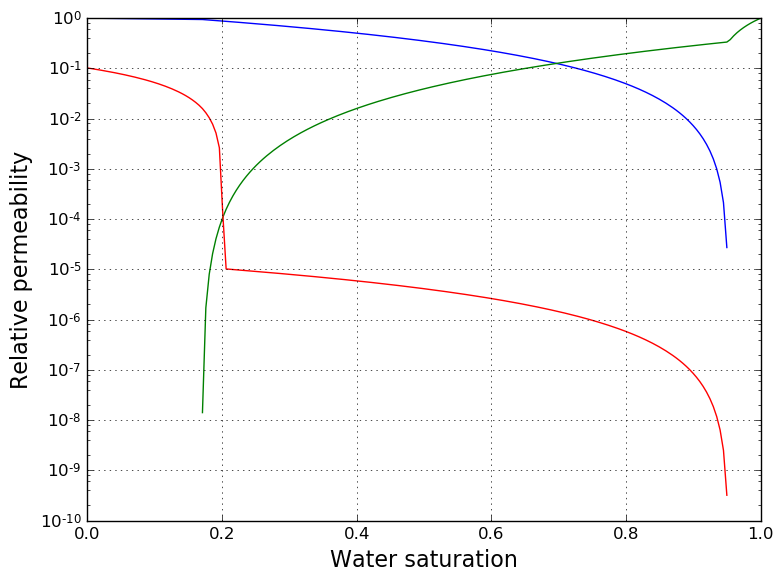

In [8]:
# visualize relperms
sw_plot=collect(linspace(0,1,200))
semilogy(sw_plot, kr(sw_plot), sw_plot, krw(sw_plot), sw_plot, krg(sw_plot))
grid()
xlabel("Water saturation", fontsize=16)
ylabel("Relative permeability", fontsize=16)
tight_layout()
savefig("relative_perms_foam")

The location of shock is calculated by solving the following equation: $$ (\frac{d f_w}{d S_w})_{S_{w,shock}} = \frac{f_w(S_{w0})-f_w(S_{w,shock})}{S_{w0}-S_{w,shock}}. $$ To solve this, we need to define the initial conditions first.

In [4]:
# define initial conditions
sw0 = 1.0
sw_end = sw0
sw_inj = 0.0
sw_in = sw_inj
# solve the nl equation to find the shock front saturation
f_shock(sw)=(dfw(sw)-(fw(sw_end)-fw(sw))./(sw0-sw))
sw_shock = fzero(f_shock, [swc+eps(),0.4])

0.19935530976403487

Now, we need to have the boundary condition to find the rarefaction wave:

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:38
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/ali/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/ali/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[9], in expression starting on line 16


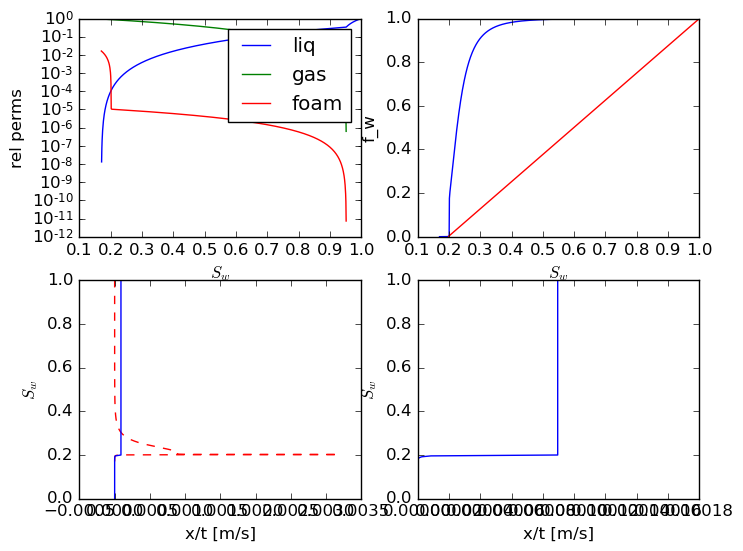

53-element Array{Float64,1}:
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 ⋮         
 0.0       
 4.03843e-9
 6.55716e-8
 2.06102e-7
 4.89622e-7
 1.09676e-6
 2.64832e-6
 8.52171e-6
 8.94787e-5
 8.94787e-5
 8.94787e-5
 0.00318291

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:38
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/ali/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/ali/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[9], in expression starting on line 16


In [9]:
s = collect(linspace(swc,1,1000))
subplot(2,2,1)
semilogy(s, krw(s), s, kr(s), s, krg(s))
xlabel(L"S_w") 
ylabel("rel perms") 
legend(["liq", "gas", "foam"])
subplot(2,2,2);
plot(s, fw(s), [sw_shock, sw_end], [fw(sw_shock), fw(sw_end)], "r")
xlabel(L"S_w") 
ylabel("f_w")
s1 = collect(linspace(sw_in, sw_shock, 50))
xt_s1 = u/phi*dfw(s1)
xt_s = u/phi*dfw(s)
xt_shock = u/phi*dfw(sw_shock)
subplot(2,2,3)
plot(xt_s, s, "r--", 
   [xt_s1, xt_shock, xt_shock, maximum(xt_s)], [s1, sw_shock, sw_end, sw_end]) 
xlabel("x/t [m/s]")
ylabel(L"S_w")
subplot(2,2,4)
plot([xt_s1, xt_shock, xt_shock, 2*xt_shock], [s1, sw_shock, sw_end, sw_end])
xlabel("x/t [m/s]")
ylabel(L"S_w")
sw_prf = [s1, sw_shock, sw_end, sw_end]
xt_prf = [xt_s1, xt_shock, xt_shock, maximum(xt_s)]

In my blog, I have also given more details about this solution and how it can be done in Octave. Now, I'm going to save it in the form of a function and use it for the calculation of recovery in a core flood. Next step is to use the recovery values and find the constants of a chosen relperm relation.

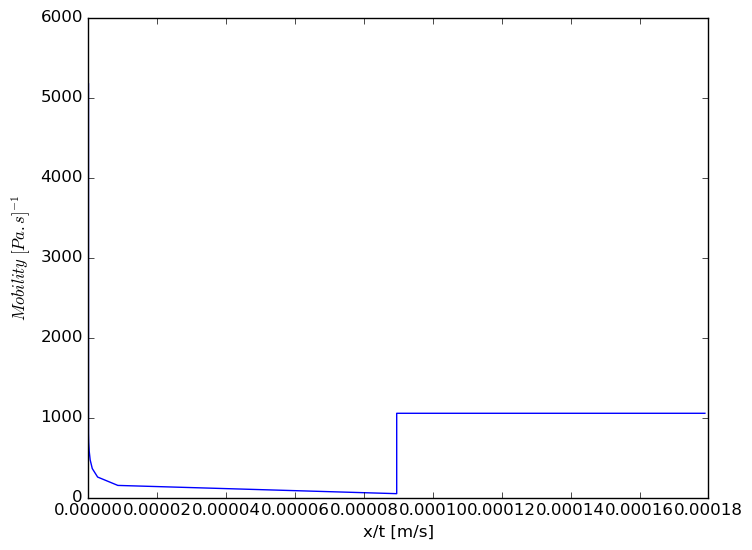

PyObject <matplotlib.text.Text object at 0x7f5cdaf59c50>

In [10]:
xt_prf=[xt_s1, xt_shock, xt_shock, 2*xt_shock]
sw_prf=[s1, sw_shock, sw_end, sw_end]
plot(xt_prf, krg(sw_prf)/mug+krw(sw_prf)/muw)
xlabel("x/t [m/s]")
ylabel(L"Mobility \; [Pa.s]^{-1}")